In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
BASE_DIR = '/content/drive/MyDrive/dataset/Thesis'
WORKING_DIR = '/content/drive/MyDrive/dataset/Thesis/work'

In [ ]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'resized')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
#store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
  features = pickle.load(f)

In [ ]:
#load the captions data
with open(os.path.join(BASE_DIR, 'caption.txt'), 'r') as f:
  next(f)
  captions_doc = f.read()

In [ ]:
#create mapping of image to captions
mapping = {}
#process line
for line in tqdm(captions_doc.split('\n')):
  #split the line by comma
  tokens = line.split('\t')
  if len(line) < 2:
    continue
  image_id, caption = tokens[0], tokens[1:]
  #remove extention from img id
  image_id = image_id.split('.')[0]
  #convert caption caption list to string
  caption = " ".join(caption)
  #create list if needed
  if image_id not in mapping:
    mapping[image_id] = []
  #store the captions
  mapping[image_id].append(caption)


  0%|          | 0/7944 [00:00<?, ?it/s]

In [ ]:
len(mapping)

2000

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
#before preprocess of text
mapping['1']

['দুইটি ছেলে সুবুজ ঘাসের উপর দাড়িয়ে আছে', 'দুইটি ছেলে ও তাদের পিছনে একটি গরু']

In [ ]:
#preprocess the text
clean(mapping)

In [ ]:
#after preprocess of text
mapping['1']

['startseq দুইটি ছেলে সুবুজ ঘাসের উপর দাড়িয়ে আছে endseq',
 'startseq দুইটি ছেলে তাদের পিছনে একটি গরু endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

7942

In [ ]:
all_captions[:10]

['startseq দুইটি ছেলে সুবুজ ঘাসের উপর দাড়িয়ে আছে endseq',
 'startseq দুইটি ছেলে তাদের পিছনে একটি গরু endseq',
 'startseq অনেক গুলো মানুষ endseq',
 'startseq অনেক গুলো মানুষ হেটে যাচ্ছে endseq',
 'startseq অনেক গুলো মানুষ মাস্ক পড়ে আছে endseq',
 'startseq দুইটি মহিলা একটি শিশু endseq',
 'startseq দুইটি মহিলা একটি শিশু বসে আছে endseq',
 'startseq একটি মহিলা শিশু কোলে নিয়ে বসে আছে একটি মহিলা হুলুদ জামা পড়ে বসে আছে endseq',
 'startseq তিনটি মেয়ে দাড়িয়ে আছে endseq',
 'startseq তিনটি মেয়ে বই হাতে দাড়িয়ে আছে endseq']

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

3137

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

32

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.80)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

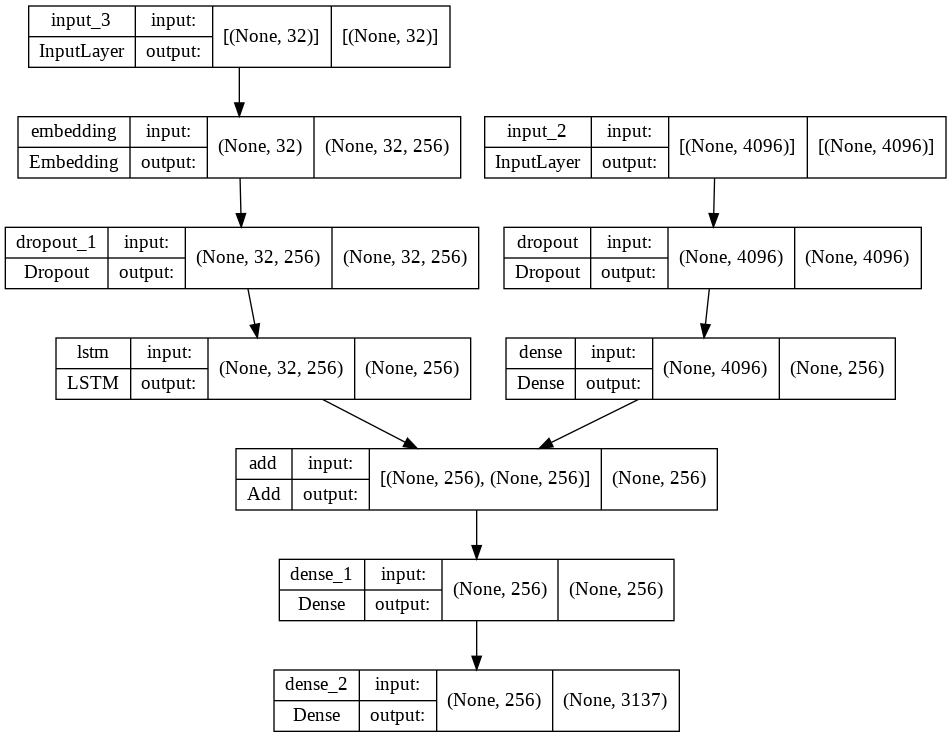

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# train the model
epochs = 50
batch_size = 16
steps = len(train) // batch_size

    # create data generator
generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
history = model.fit(generator, epochs=50, steps_per_epoch=steps, verbose=1)


#for i in range(epochs):
    # create data generator
    #generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
   # h = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


Epoch 1/50
112/112 [==============================] - 15s 138ms/step - loss: 1.3650 - accuracy: 0.6249
Epoch 2/50
112/112 [==============================] - 16s 140ms/step - loss: 1.2942 - accuracy: 0.6402
Epoch 3/50
112/112 [==============================] - 17s 148ms/step - loss: 1.2385 - accuracy: 0.6559
Epoch 4/50
112/112 [==============================] - 15s 133ms/step - loss: 1.1835 - accuracy: 0.6641
Epoch 5/50
112/112 [==============================] - 15s 135ms/step - loss: 1.1439 - accuracy: 0.6746
Epoch 6/50
112/112 [==============================] - 15s 133ms/step - loss: 1.1043 - accuracy: 0.6835
Epoch 7/50
112/112 [==============================] - 15s 135ms/step - loss: 1.0691 - accuracy: 0.6898
Epoch 8/50
112/112 [==============================] - 15s 134ms/step - loss: 1.0353 - accuracy: 0.6980
Epoch 9/50
112/112 [==============================] - 17s 151ms/step - loss: 1.0114 - accuracy: 0.7047
Epoch 10/50
112/112 [==============================] - 15s 134ms/step - l

In [ ]:
history.history??

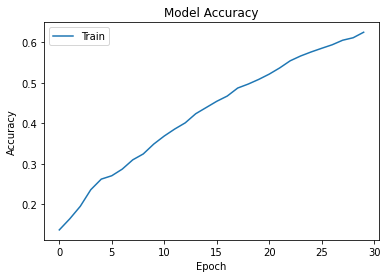

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

  0%|          | 0/200 [00:00<?, ?it/s]

BLEU-1: 0.428738
BLEU-2: 0.223397
BLEU-3: 0.129654
BLEU-4: 0.058739


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "resized", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq কয়েকটি পাখি উড়ছে। endseq
startseq হলুদ আকাশে কয়েকটি পাখি উড়ছে। endseq
startseq সকালের আকাশে কয়েকটি পাখি উড়ছে। endseq
startseq সকালের আকাশে কয়েকটি পাখি উড়ছে এবং কিছু গাছ দেখা যায়। endseq
startseq আকাশে কয়েকটা পাখি উড়ছে। endseq
--------------------Predicted--------------------
startseq একটি প্রাকৃতিক দৃশ্য endseq


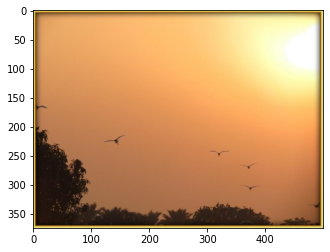

In [ ]:
generate_caption("1887.jpg")

---------------------Actual---------------------
startseq একটি মুখোস জামা আছে এবং পিছনে একজন মানুষ আছে। endseq
startseq একটি মুখোস সাদা জামা আছে এবং পিছনে একজন মানুষ আছে। endseq
startseq একটি মুখোস জামা আছে এবং পিছনে একজন মানুষ সবুজ ধানের ক্ষেতের মাঝে দাঁড়িয়ে আছে। endseq
startseq একটি মুখোস জামা আছে এবং পিছনে একজন মানুষ সবুজ ধানের ক্ষেতের মাঝে মুখোস পড়ে আছে। endseq
startseq ধান ক্ষেতে একজন পুতুল হয়ে দাঁড়িয়ে আছে। endseq
--------------------Predicted--------------------
startseq দুইটি ছেলে একসাথে ফুটবল খেলছে endseq


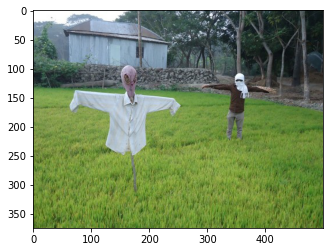

In [ ]:
generate_caption("1883.jpg")